In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
import mdtraj
plt.rc('font', family='serif')

from msmbuilder.example_datasets import FsPeptide
dataset = FsPeptide().get()
fs_trajectories = dataset.trajectories
fs_t = fs_trajectories[0]

loading trajectory_1.xtc...
loading trajectory_10.xtc...
loading trajectory_11.xtc...
loading trajectory_12.xtc...
loading trajectory_13.xtc...
loading trajectory_14.xtc...
loading trajectory_15.xtc...
loading trajectory_16.xtc...
loading trajectory_17.xtc...
loading trajectory_18.xtc...
loading trajectory_19.xtc...
loading trajectory_2.xtc...
loading trajectory_20.xtc...
loading trajectory_21.xtc...
loading trajectory_22.xtc...
loading trajectory_23.xtc...
loading trajectory_24.xtc...
loading trajectory_25.xtc...
loading trajectory_26.xtc...
loading trajectory_27.xtc...
loading trajectory_28.xtc...
loading trajectory_3.xtc...
loading trajectory_4.xtc...
loading trajectory_5.xtc...
loading trajectory_6.xtc...
loading trajectory_7.xtc...
loading trajectory_8.xtc...
loading trajectory_9.xtc...


In [15]:
from msmbuilder.example_datasets import AlanineDipeptide
ala = AlanineDipeptide().get()
t = ala.trajectories[1]

In [16]:
from msmbuilder.featurizer import DihedralFeaturizer
dih_model = DihedralFeaturizer()
traj = dih_model.fit_transform([t])

In [26]:
from msmbuilder.decomposition import tICA
tica = tICA(lag_time=100,n_components=2)
tica.fit(traj)
X = tica.transform(traj)

In [27]:
from scipy.spatial.distance import pdist
raw_dist = pdist(traj[0])
tica_dist = pdist(X[0])

In [ ]:
from sklearn.decomposition import 

In [ ]:
plt.scatter(

In [19]:
len(traj[0])

10000

In [28]:
from scipy.spatial.distance import squareform

def plot_dist_mat(dist_mat,filename):
    plt.imshow(dist_mat,interpolation='none',cmap='Blues');
    plt.savefig(filename,dpi=300)
    

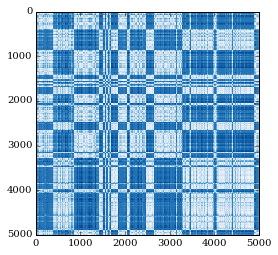

In [30]:
d = squareform(raw_dist)[::2,::2]

plot_dist_mat(d,'raw_dist_mat.png')

In [ ]:
d = squareform(pdist(np.vstack(X_tica)))

plot_dist_mat(d,'tica_dist_mat.png')

In [6]:
# create a combination trajectory from 10 of the individual trajectories
fs_group = [ind[::15] for ind in fs_trajectories[:10]]

len(fs_group)*len(fs_group[0])

6670

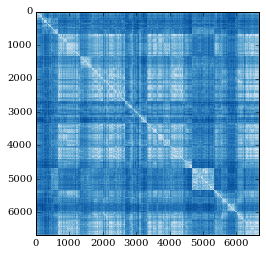

In [52]:
# concatenate them into a single trajectory
fs_group_traj = fs_group[0]
for ind in fs_group[1:]:
    fs_group_traj = fs_group_traj + ind
fs_traj = dih_model.fit_transform([fs_group_traj])
raw_dist = pdist(fs_traj[0])

d = squareform(raw_dist)

plot_dist_mat(d,'fs_raw_dist_mat.png')

In [81]:
# compute RMSD distance matrix

rmsd_mat = np.zeros((len(fs_group_traj),len(fs_group_traj)))

for i in range(1,len(fs_group_traj)):
    rmsd_mat[i,:i] = rmsd(fs_group_traj[:i],fs_group_traj,i)

In [ ]:
rms

In [195]:
rmsd_mat = rmsd_mat + rmsd_mat.T

In [196]:
plot_dist_mat(rmsd_mat,'fs_rmsd.png')

In [63]:
xyz = fs_group_traj.xyz

In [65]:
xyz.shape

(6670, 264, 3)

In [95]:
# compute weights
#from MDAnalysis.analysis import align
from mdtraj.geometry import alignment

def compute_atomwise_deviation_xyz(X_xyz,Y_xyz):
    X_prime = alignment.transform(X_xyz, Y_xyz)
    delta = X_prime - Y_xyz
    deviation = ((delta**2).sum(1))**0.5
    return deviation

def compute_atomwise_deviation(X,Y):
    return compute_atomwise_deviation_xyz(X.xyz[0],Y.xyz[0])

tau=20
deviations = []

for i,fs_t in enumerate(fs_trajectories):
    print(i)
    n_frames=len(fs_t)-tau
    n_atoms = fs_t.n_atoms
    atomwise_deviations=np.zeros((n_frames,n_atoms))
    for i in range(n_frames):
        atomwise_deviations[i] = compute_atomwise_deviation(fs_t[i],fs_t[i+tau])
    deviations.append(atomwise_deviations)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [96]:
# compute weights as inverse mean deviation
mean = np.mean(np.vstack(deviations),0)
weights = 1/mean

In [98]:
np.save('fs_atomwise_deviations_tau=20.npy',np.vstack(deviations))

In [100]:
np.vstack(deviations).shape

(279440, 264)

In [99]:
mean = np.mean(np.vstack(deviations),0)
stdev = np.std(np.vstack(deviations),0)
plt.plot(mean,c='darkblue')
#plt.plot(mean+stdev,c='blue',linestyle='--')
#plt.plot(mean-stdev,c='blue',linestyle='--')
plt.fill_between(range(len(mean)),mean-stdev,mean+stdev,color='blue',alpha=0.3)
plt.xlabel('Atom index')
plt.ylabel(r'Mean displacement, computed at $\tau=1$ns')
plt.title('Atomwise deviation from Fs peptide simulation')
plt.xlim(0,263)
plt.savefig('atomwise_deviation.pdf')

In [72]:
# compute weighted RMSD distance matrix


from MDAnalysis.analysis import align
learned_weights = weights

wrmsd_matrix = np.zeros((len(xyz),len(xyz)))

for i in range(len(xyz)):
    if i % 100 == 0:
        print(i)
    for j in range(i):
        wrmsd_matrix[i,j] = align.rms.rmsd(xyz[i],xyz[j],weights)

In [105]:
learned_weights = weights

In [ ]:
# compute autocorrelation plots

# see below!



In [ ]:
# use these distances in k-medoids clustering

In [104]:
from alt_kmed import AltMiniBatchKMedoids

In [106]:
def wrmsd(X,Y):
    return align.rms.rmsd(X,Y,learned_weights)

In [107]:
kmed = AltMiniBatchKMedoids(metric=('callable',wrmsd))

In [108]:
kmed.fit(xyz)

AltMiniBatchKMedoids(batch_size=100, max_iter=5, max_no_improvement=10,
           metric=('callable', <function wrmsd at 0x174355e60>),
           n_clusters=8, random_state=None)

In [109]:
all_xyz = np.vstack([ind.xyz for ind in fs_trajectories])

In [110]:
all_xyz.shape

(280000, 264, 3)

In [111]:
clusters = kmed.transform(all_xyz)

In [119]:
clusters = np.array(clusters,dtype=int)

In [120]:
np.save('wrmsd_clusters.npy',clusters)

In [121]:
clusters_list = []
ind = 0
for i in range(len(fs_trajectories)):
    length = len(fs_trajectories[i])
    clusters_list.append(clusters[ind:ind+length])
    ind+= length

In [2]:
import pyemma

In [3]:
deviations = np.load('fs_atomwise_deviations_tau=20.npy')
mean = np.mean(deviations)
weights = 1/mean

In [4]:
from msmbuilder.featurizer import DihedralFeaturizer
dih_model = DihedralFeaturizer()
X = dih_model.fit_transform(fs_trajectories)

In [5]:
X_tica = pyemma.coordinates.tica(X,lag=20).transform(X)

In [122]:
import pyemma
from pyemma.msm import its

In [129]:
lags = [1,2,3,4,5,10,20,50,100,200,300,400,500,1000]
implied_timescales = its(clusters_list,lags,nits=1,errors='bayes')

In [136]:
implied_timescales.sample_std

array([[   0.72403819],
       [   1.33682384],
       [   2.26689548],
       [   2.8437467 ],
       [   3.30752266],
       [   5.84986138],
       [   8.42323087],
       [  17.40073782],
       [  27.62846603],
       [  65.83622162],
       [  74.91780514],
       [  99.17232957],
       [ 138.26448743],
       [ 230.15441369]])

In [160]:
wrmsd_timescales = implied_timescales
wrmsd_mean = wrmsd_timescales.timescales[:,0]
wrmsd_std = wrmsd_timescales.sample_std[:,0]

In [157]:
# unweighted rmsd
kmed_ = msmbuilder.cluster.MiniBatchKMedoids(metric='rmsd')
rmsd_clusters = kmed_.fit_transform(fs_trajectories)

rmsd_timescales = its(rmsd_clusters,lags,nits=1,errors='bayes')

rmsd_mean = rmsd_timescales.timescales[:,0]
rmsd_std = rmsd_timescales.sample_std[:,0]

In [188]:
from numpy.linalg import det
def BC(X,Y):
    return 1 - det(X.T.dot(Y)) / np.sqrt(det(X.T.dot(X)) * det(Y.T.dot(Y)))

In [189]:
# unweighted binet-cauchy

kmed_ = AltMiniBatchKMedoids(metric=('callable',BC))
kmed_.fit(xyz)
bc_clusters = kmed_.transform(all_xyz)


bc_clusters = np.array(bc_clusters,dtype=int)
clusters_list = []
ind = 0
for i in range(len(fs_trajectories)):
    length = len(fs_trajectories[i])
    clusters_list.append(bc_clusters[ind:ind+length])
    ind+= length

bc_timescales = its(clusters_list,lags,nits=1,errors='bayes')

bc_mean = bc_timescales.timescales[:,0]
bc_std = bc_timescales.sample_std[:,0]

In [190]:
def BC_w(X,Y,M=None):
    if M==None:
        M = np.diag(np.ones(len(X)))
        
    return det(X.T.dot(M).dot(Y)) / np.sqrt(det(X.T.dot(M).dot(X)) * det(Y.T.dot(M).dot(Y)))

In [191]:
def weighted_BC(X,Y):
    M = np.diag(learned_weights)
    return 1 - (det(X.T.dot(M).dot(Y)) / np.sqrt(det(X.T.dot(M).dot(X)) * det(Y.T.dot(M).dot(Y))))

In [192]:
# weighted binet-cauchy

kmed_ = AltMiniBatchKMedoids(metric=('callable',weighted_BC))
kmed_.fit(xyz)
wbc_clusters = kmed_.transform(all_xyz)


wbc_clusters = np.array(wbc_clusters,dtype=int)
clusters_list = []
ind = 0
for i in range(len(fs_trajectories)):
    length = len(fs_trajectories[i])
    clusters_list.append(wbc_clusters[ind:ind+length])
    ind+= length

wbc_timescales = its(clusters_list,lags,nits=1)#,errors='bayes')

wbc_mean = wbc_timescales.timescales[:,0]
wbc_std = wbc_timescales.sample_std[:,0]

RuntimeError: Cannot compute sample mean, because no samples were generated  try calling bootstrap() before

In [146]:
# raw
kmed_ = msmbuilder.cluster.MiniBatchKMedoids()
raw_clusters = kmed_.fit_transform(dih_model.fit_transform(fs_trajectories))

raw_timescales = its(raw_clusters,lags,nits=1,errors='bayes')

raw_mean = raw_timescales.timescales[:,0]
raw_std = raw_timescales.sample_std[:,0]

In [152]:
# tica
from pyemma.coordinates import tica

kmed_ = msmbuilder.cluster.MiniBatchKMedoids()
X = dih_model.fit_transform(fs_trajectories)
X_tica = tica(X,lag=20).transform(X)
tica_clusters = kmed_.fit_transform(X_tica)

tica_timescales = its(tica_clusters,lags,nits=1,errors='bayes')

tica_mean = tica_timescales.timescales[:,0]
tica_std = tica_timescales.sample_std[:,0]

In [ ]:
# tica pairwise

kmed_ = msmbuilder.cluster.MiniBatchKMedoids()
feat = pyemma.coordinates.data.featurizer

X = dih_model.fit_transform(fs_trajectories)
X_tica = tica(X,lag=20).transform(X)
tica_clusters = kmed_.fit_transform(X_tica)



tica_timescales = its(tica_clusters,lags,nits=1,errors='bayes')

tica_mean = tica_timescales.timescales[:,0]
tica_std = tica_timescales.sample_std[:,0]

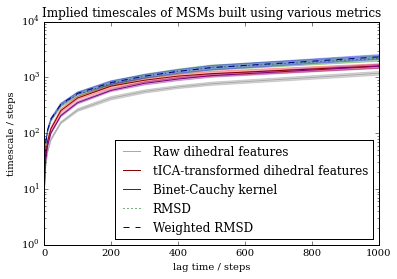

In [193]:
# Raw Dihedral features
mean = raw_mean
std = raw_std
plt.plot(lags,mean,c='darkgrey',label='Raw dihedral features')
plt.fill_between(lags,mean-std,mean+std,alpha=0.3,color='grey')

# tICA (dihedral)
mean = tica_mean
std = tica_std
plt.plot(lags,mean,c='darkred',label='tICA-transformed dihedral features')
plt.fill_between(lags,mean-std,mean+std,alpha=0.3,color='red')

# Binet-Cauchy kernel
mean = bc_mean
std = bc_std

plt.plot(lags,mean,c='purple',linestyle='-',label='Binet-Cauchy kernel')
plt.fill_between(lags,mean-std,mean+std,alpha=0.3,color='purple')

# RMSD
mean = rmsd_mean
std = rmsd_std

plt.plot(lags,mean,c='darkgreen',linestyle=':',label='RMSD')
plt.fill_between(lags,mean-std,mean+std,alpha=0.3,color='green')

# Weighted RMSD
mean = wrmsd_mean
std = wrmsd_std

plt.plot(lags,mean,c='darkblue',linestyle='--',label='Weighted RMSD')
plt.fill_between(lags,mean-std,mean+std,alpha=0.3,color='blue')


plt.legend(loc='best')

plt.yscale('log')
plt.xlabel('lag time / steps')
plt.ylabel('timescale / steps')

plt.title('Implied timescales of MSMs built using various metrics')

plt.savefig('implied_timescales_.pdf')

In [143]:
std.shape,mean.shape,len(lags)

((14,), (14,), 14)

In [126]:
pyemma.plots.plot_implied_timescales(implied_timescales)

In [ ]:
implied_timescales

In [3]:
from mdtraj import rmsd

In [4]:
rmsd(fs_t[:10],fs_t[0])

array([ 0.        ,  0.19644617,  0.21715195,  0.24179077,  0.2577042 ,
        0.19864696,  0.19607922,  0.20785291,  0.25813895,  0.29692328], dtype=float32)

In [5]:
def rmsd_diffs(traj,lag=10):
    ''' at each frame, calculate the rmsd to the next 10 or so frames'''
    all_rmsd_diffs = np.zeros((traj.n_frames-lag,lag))
    for i in range(len(all_rmsd_diffs)):
        all_rmsd_diffs[i] = rmsd(traj[i:(lag+i)],traj[i])
    return all_rmsd_diffs

In [6]:
diffs = rmsd_diffs(fs_t,100)

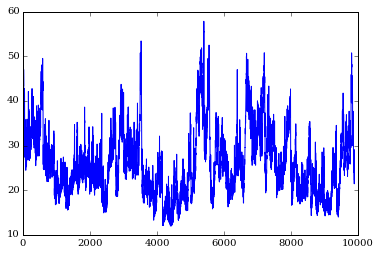

In [7]:
plt.plot(diffs.sum(1))

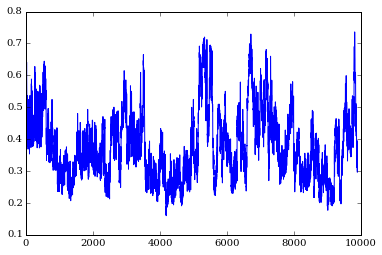

In [8]:
plt.plot(diffs.max(1))

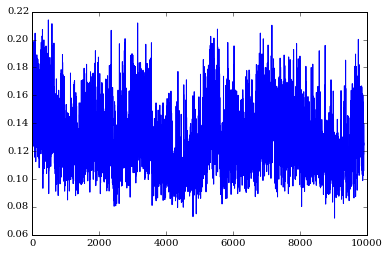

In [9]:
plt.plot(diffs[:,1:].min(1))

In [10]:
diffs.shape

(9900, 100)

In [11]:
plt.plot(np.median(diffs[:,1:],1))

In [12]:
def ma(data,n=50):
    ''' compute moving average'''
    w = np.array([1.0/n]*n)
    return np.convolve(data,w,'valid')

In [13]:
diffs.shape

(9900, 100)

In [14]:
plt.plot(ma(np.median(diffs[:,1:],1)))
plt.figure()
plt.plot(ma(np.mean(diffs[:,1:],1)))
plt.figure()
plt.plot(ma(np.max(diffs[:,1:],1)))
#plt.plot(ma(np.min(diffs[:,1:],1)))

In [15]:
diffs_t = rmsd_diffs(t,100)

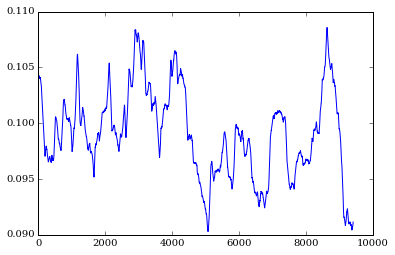

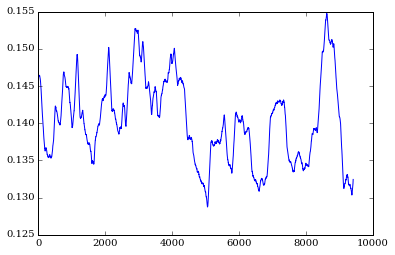

In [16]:
n=500
plt.plot(ma(np.median(diffs_t[:,1:],1),n))
plt.figure()
plt.plot(ma(np.mean(diffs_t[:,1:],1),n))
plt.figure()
plt.plot(ma(np.max(diffs_t[:,1:],1),n))
#plt.plot(ma(np.min(diffs[:,1:],1)))

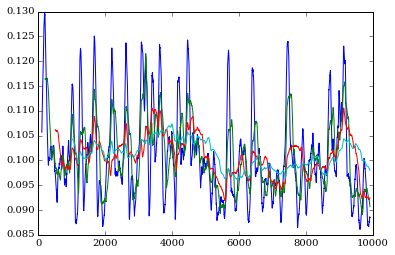

In [17]:
ns = [100,200,500,1000]
for n in ns:
    plt.plot(range(n-1,len(diffs_t)),ma(np.median(diffs_t[:,1:],1),n))

In [18]:
ma(np.median(diffs_t[:,1:],1),n).shape

(8900,)

In [19]:
n

1000

In [20]:
len(diffs_t)-n

8899

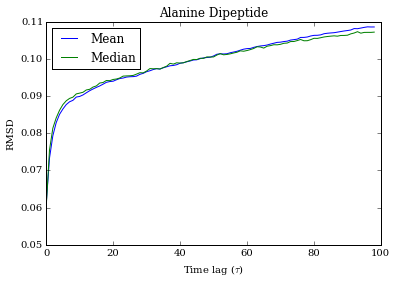

In [21]:
plt.plot(diffs_t.mean(0)[1:],label='Mean')
plt.plot(np.median(diffs_t[:,1:],0),label='Median')
#plt.plot(np.min(diffs_t[:,1:],0),label='Min')
#plt.plot(np.max(diffs_t[:,1:],0),label='Max')
plt.xlabel(r'Time lag ($\tau$)')
plt.ylabel('RMSD')
plt.legend(loc='best')
plt.title('Alanine Dipeptide')

In [22]:
diffs_t.shape

(9899, 100)

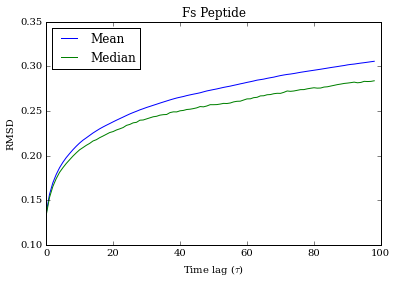

In [23]:
plt.plot(diffs.mean(0)[1:],label='Mean')
plt.plot(np.median(diffs[:,1:],0),label='Median')
#plt.plot(np.min(diffs[:,1:],0),label='Min')
#plt.plot(np.max(diffs[:,1:],0),label='Max')
plt.xlabel(r'Time lag ($\tau$)')
plt.ylabel('RMSD')
plt.legend(loc='best')
plt.title('Fs Peptide')

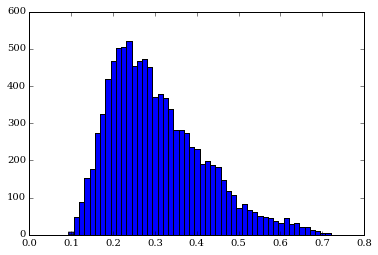

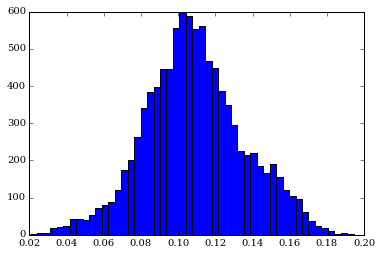

In [24]:
plt.hist(diffs[:,-1],bins=50);
plt.figure()
plt.hist(diffs_t[:,-1],bins=50);

In [25]:
import sys
sys.path.append('../projects/metric-learning')
import weighted_rmsd
reload(weighted_rmsd)

<module 'weighted_rmsd' from '../projects/metric-learning/weighted_rmsd.pyc'>

In [26]:
from weighted_rmsd import wRMSD,compute_kinetic_weights

In [204]:
weights = compute_kinetic_weights(t,10)
weights_10 = compute_kinetic_weights(t,10)
weights_100 = compute_kinetic_weights(t,100)

In [227]:
def windowed_deviations(traj,lags=np.arange(10)*10+1):
    ''' at each frame, calculate the atomwise deviations to the next 10 or so frames'''
    all_dev_diffs = np.zeros((traj.n_frames-max(lags),len(lags),traj.n_atoms))
    for i in range(len(all_dev_diffs)):
        for j,tau in enumerate(lags):
            all_dev_diffs[i,j-1] = weighted_rmsd.compute_atomwise_deviation(traj[i+j],traj[i])
        if i % 1000 == 0:
            print(i)
    return all_dev_diffs

In [228]:
dev_t = windowed_deviations(t)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [229]:
dev_t.shape

(9908, 10, 22)

In [30]:
dev_t.shape

(9899, 100, 22)

In [31]:
dev_t.dot(weights).shape

(9899, 100)

In [32]:
%timeit dev_t.dot(weights)

10 loops, best of 3: 34.8 ms per loop


In [47]:
weights = (weights/np.sqrt(sum(weights**2)))
weights.mean()

0.18414783968453527

In [636]:
def norm(w):
    return np.abs(w)/np.sqrt(np.sum(w**2))

In [48]:
def plot_diffs(diffs,title='',label=''):
    if len(label)>0:
        plt.plot(diffs.mean(0)[1:],label=label)
    else:
        plt.plot(diffs.mean(0)[1:])
    plt.xlabel(r'Time lag ($\tau$)')
    plt.ylabel('RMSD')

    if len(title)>0:
        plt.title(title)

In [49]:
n_atoms = len(weights)

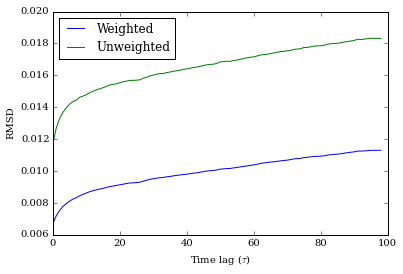

In [52]:
plot_diffs(dev_t.dot(norm(weights))/n_atoms,label='Weighted')
plot_diffs(dev_t.dot(norm(np.ones(dev_t.shape[-1])))/n_atoms,label='Unweighted')
#plot_diffs(diffs,label='Unweighted')
plt.legend(loc='best')

In [116]:
def objective(weights):
    normalized_weights = norm(weights)
    return np.sum(np.dot(dev_t,normalized_weights)**2)*np.min(weights >= 0)

In [117]:
def lnprob(weights):
    return -np.log(objective(weights))

In [118]:
ones = np.ones(len(weights))
print(objective(ones),objective(weights))
print(lnprob(ones),lnprob(weights))

(142357.34728641112, 53677.060161727517)
(-11.866095705609629, -10.890741004157169)


In [119]:
%timeit objective(weights)

10 loops, best of 3: 35.2 ms per loop


In [120]:
import emcee

In [121]:
weights.shape

(22,)

In [122]:
lnprob(weights+npr.randn(n_atoms)*0.01)

-10.871543027811178

In [123]:
from autograd import grad
import autograd.numpy as np

In [113]:
grad_objective = grad(objective)

In [114]:
grad_objective(weights)

array([ 53223.56740511, -17864.30448145,  53366.86830639,  53259.49151462,
       -11385.08108938,  29740.02818509, -23251.88545877,  15193.74002534,
       -29306.54675912,  -8842.7257977 , -17290.10163157,  31061.0076599 ,
        30729.35418509,  30585.41374849, -11605.92230607,  39055.97039275,
       -14518.18901346,  29112.47084265, -13450.6359189 ,  53865.61097045,
        53557.65771912,  53769.56297641])

In [130]:
n_walkers = n_atoms*2
sampler = emcee.EnsembleSampler(n_walkers, n_atoms, lambda w:-objective(w))
sampler.run_mcmc(np.random.randn(n_walkers,n_atoms), 100)

(array([[  2.04838002e+19,   1.09791106e+19,  -2.40203009e+18,
           1.47598905e+19,  -2.37245109e+19,   4.46252773e+18,
          -1.20075333e+19,  -3.47695230e+18,  -1.13709004e+19,
           1.58534115e+18,  -2.39525681e+18,  -1.63931874e+19,
           4.96616941e+18,  -1.41884309e+19,  -1.25881750e+19,
          -1.45922105e+19,   1.08999834e+19,  -7.36863242e+18,
           4.35265354e+18,   1.57625999e+19,   1.55486221e+19,
          -9.69565931e+18],
        [  7.38589319e+19,   3.95876571e+19,  -8.66109871e+18,
           5.32200709e+19,  -8.55440268e+19,   1.60906640e+19,
          -4.32958544e+19,  -1.25369218e+19,  -4.10003237e+19,
           5.71630094e+18,  -8.63664965e+18,  -5.91093170e+19,
           1.79066463e+19,  -5.11595317e+19,  -4.53894765e+19,
          -5.26154607e+19,   3.93023493e+19,  -2.65692481e+19,
           1.56944894e+19,   5.68356041e+19,   5.60640377e+19,
          -3.49598815e+19],
        [  9.51447067e+19,   5.09966035e+19,  -1.11571230e+19,

In [131]:
sampler.flatchain.shape

(4400, 22)

In [132]:
normed_chain = np.array([norm(s) for s in sampler.flatchain])

In [133]:
normed_chain

array([[-0.15196116,  0.53463089,  0.05975893, ...,  0.20109551,
         0.19115583, -0.08688488],
       [-0.13607448,  0.50745558,  0.04680355, ...,  0.18634484,
         0.18072572, -0.07982799],
       [-0.13607448,  0.50745558,  0.04680355, ...,  0.18634484,
         0.18072572, -0.07982799],
       ..., 
       [-0.35751461, -0.19162426,  0.04192417, ..., -0.27511308,
        -0.27137828,  0.16922351],
       [-0.35751461, -0.19162426,  0.04192417, ..., -0.27511308,
        -0.27137828,  0.16922351],
       [-0.35751459, -0.19162425,  0.04192405, ..., -0.27511304,
        -0.27137829,  0.16922349]])

In [128]:
import triangle
reload(triangle)

<module 'triangle' from '/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/triangle.pyc'>

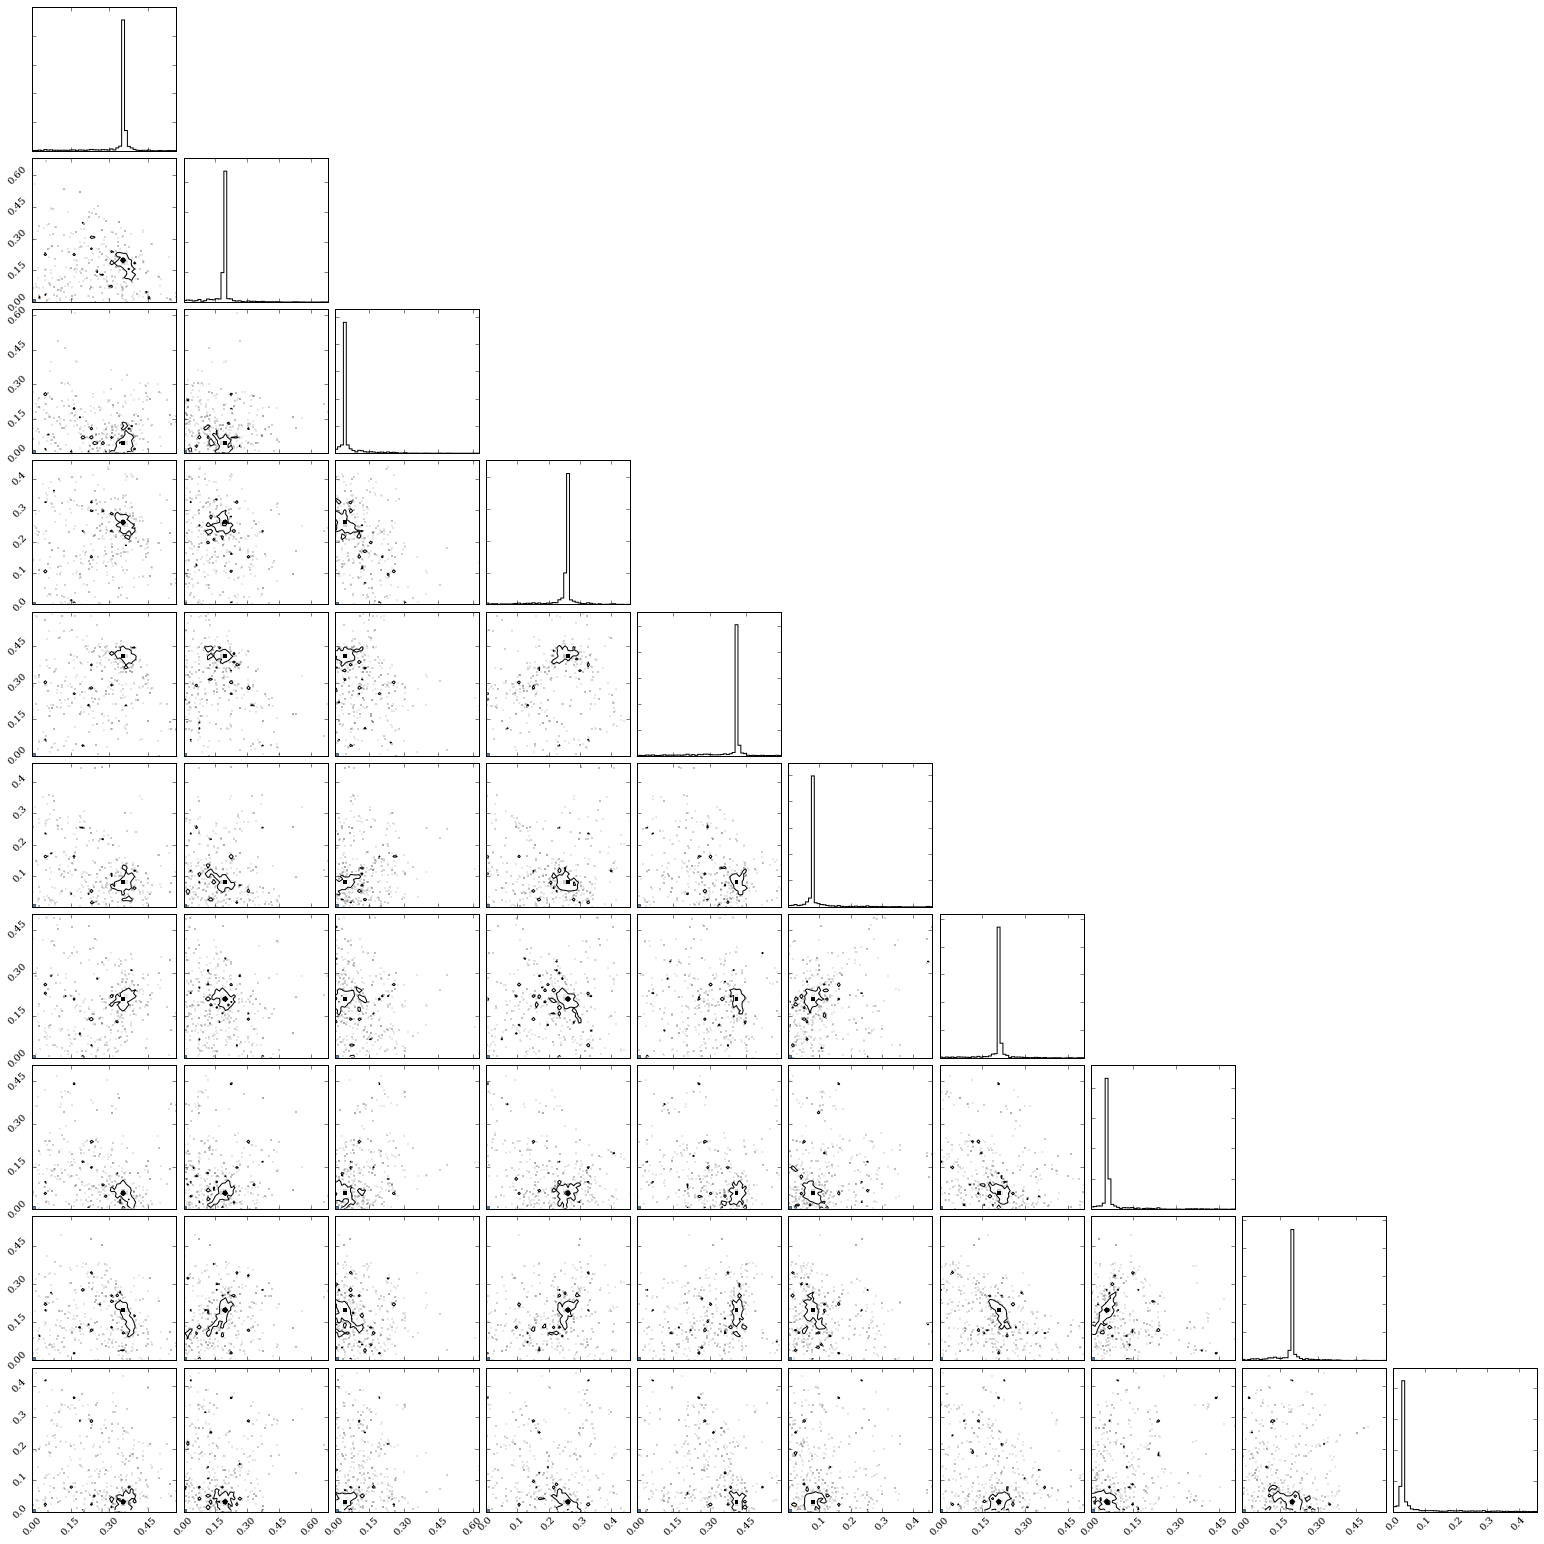

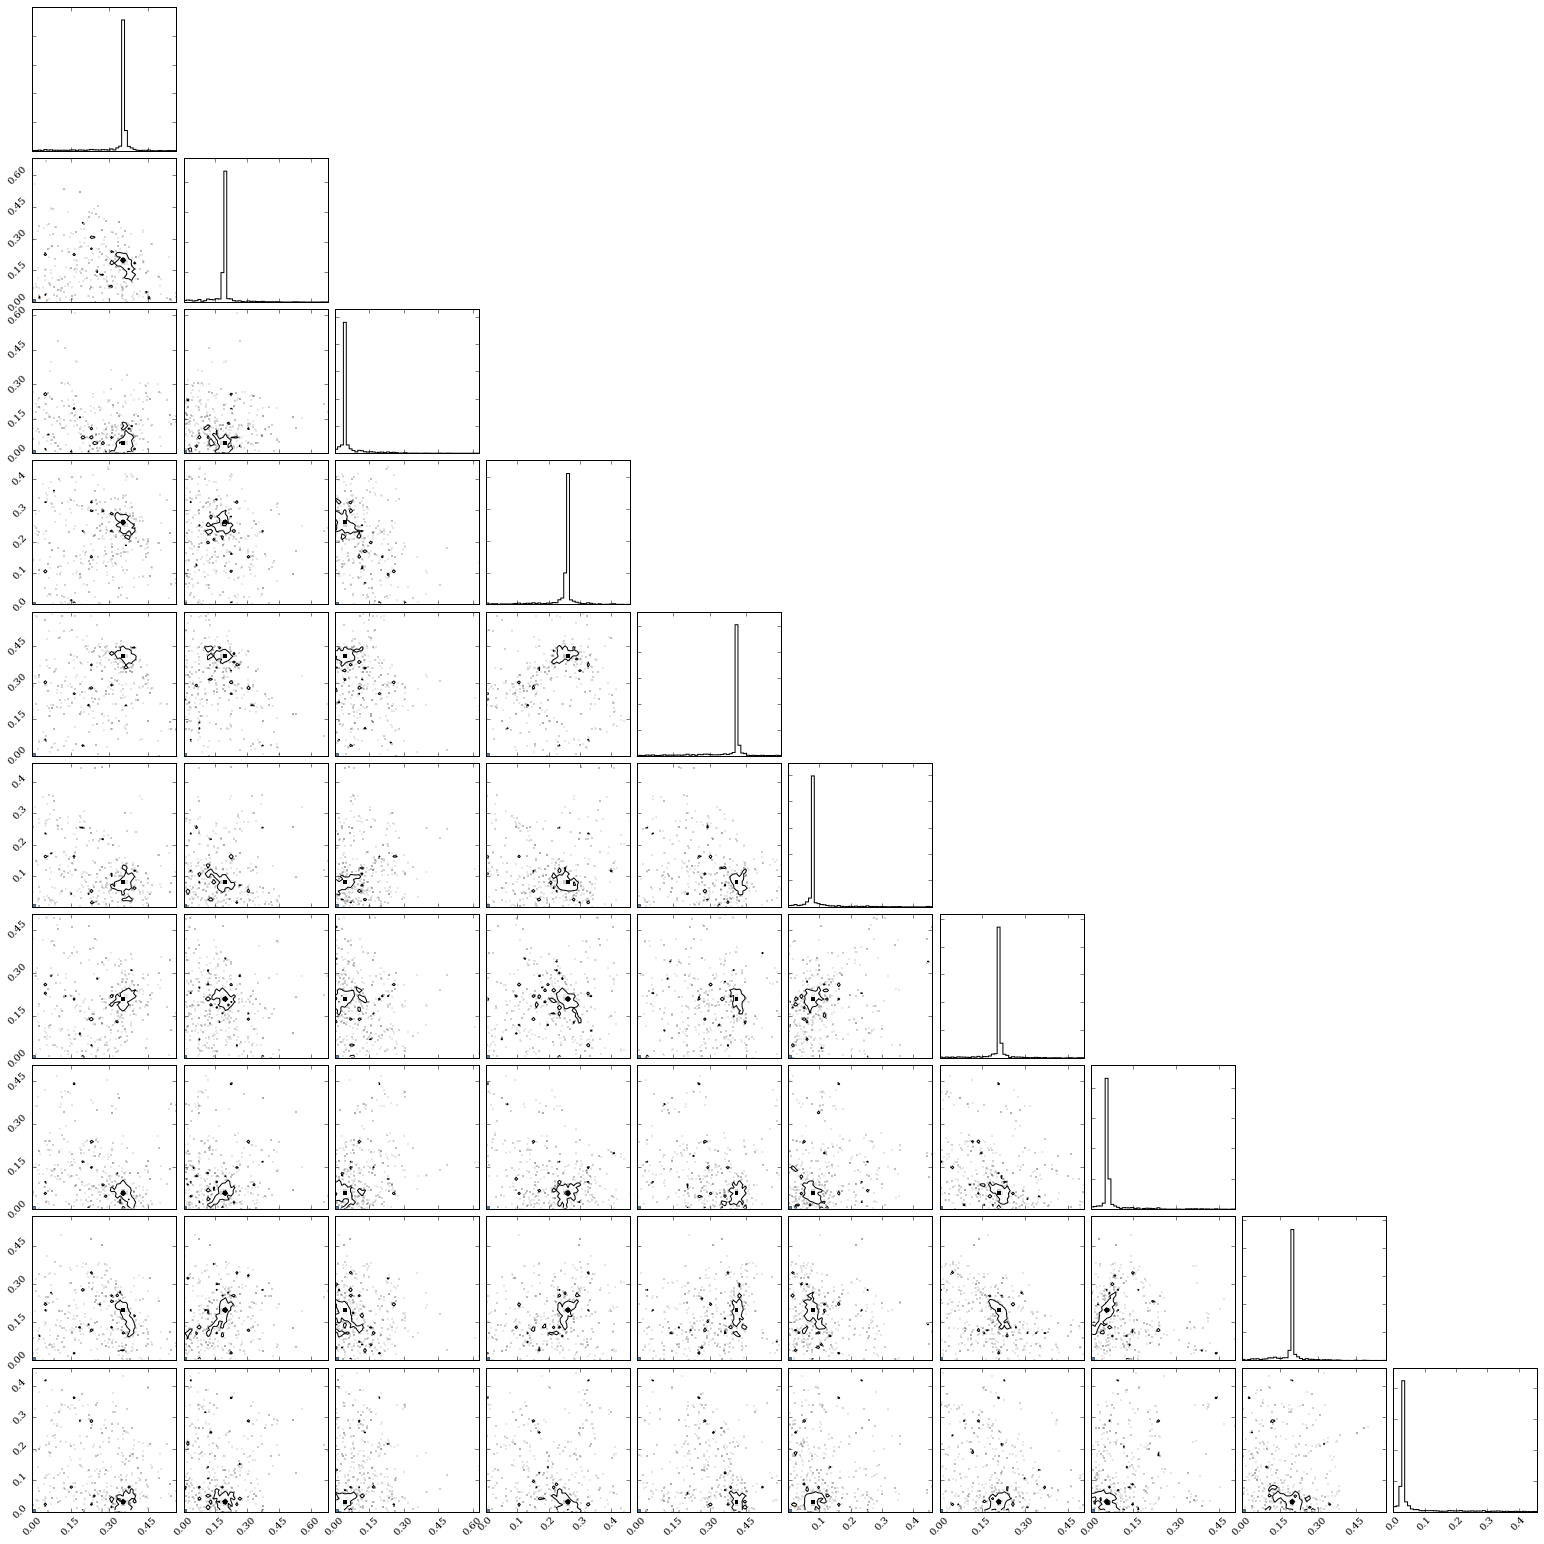

In [135]:
samples = np.abs(normed_chain[1000:,:10])
triangle.corner(samples,truths=np.zeros(samples.shape[1]))

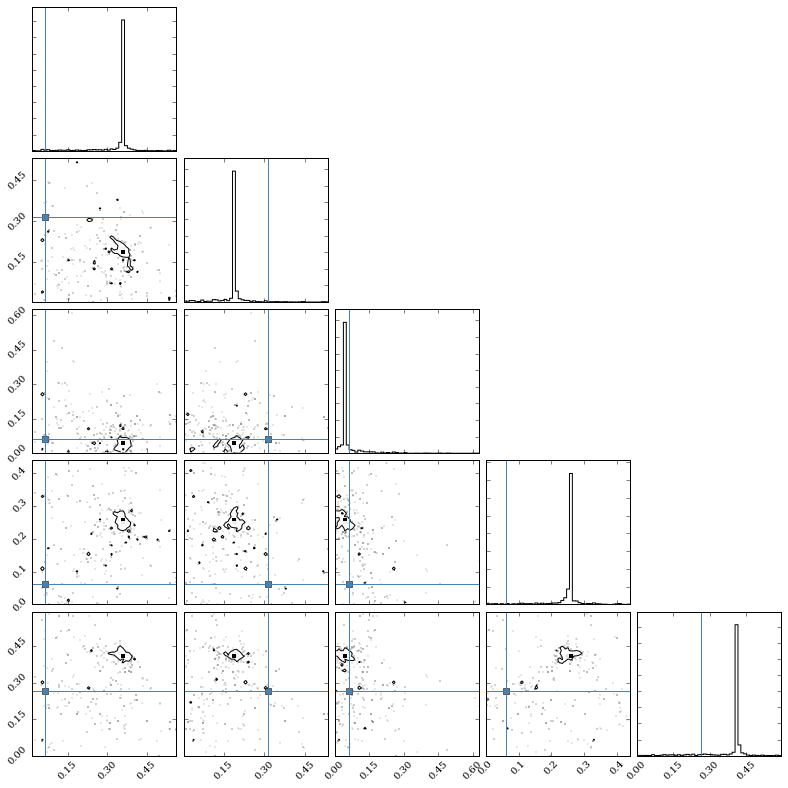

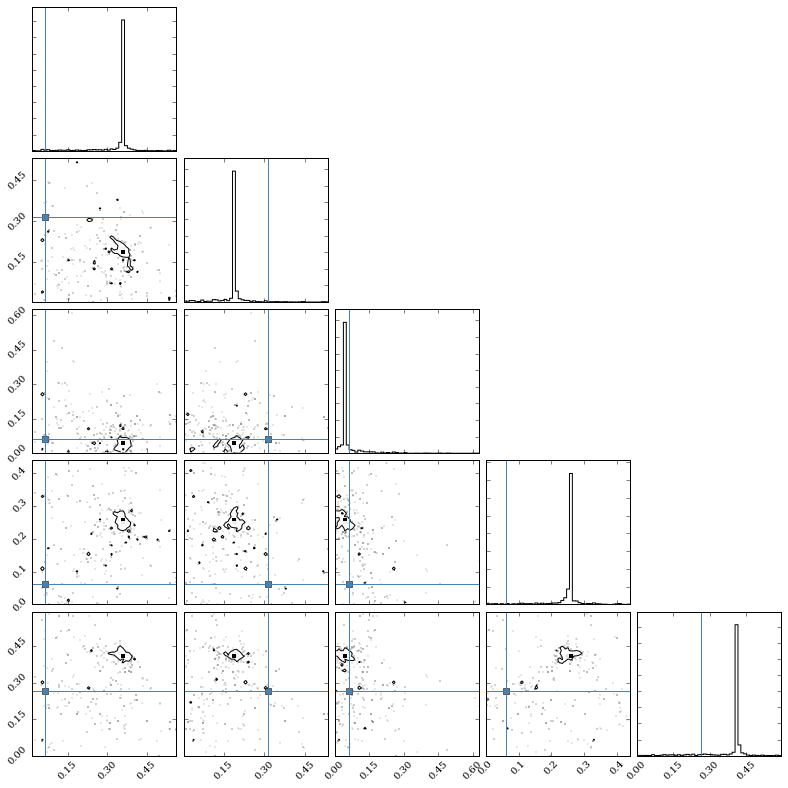

In [162]:
samples = np.abs(normed_chain[len(normed_chain)/2:,:5])
triangle.corner(samples,truths=weights[:samples.shape[1]])

In [97]:
objs = [objective(s) for s in normed_chain[-500:]]

In [100]:
np.argmin(objs)

497

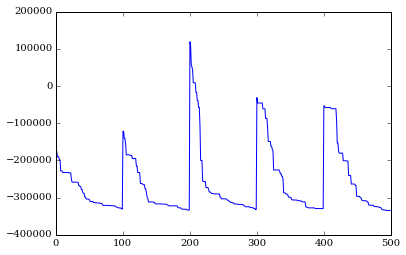

In [101]:
plt.plot(objs)

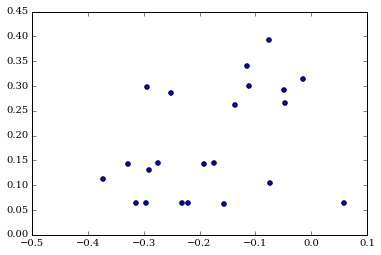

In [103]:
plt.scatter(normed_chain[-1],norm(weights))

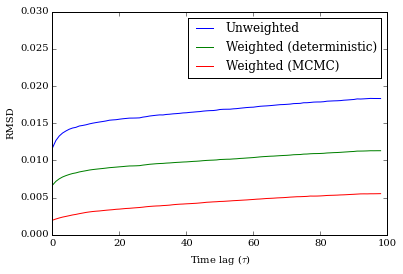

In [157]:
plot_diffs(np.abs(dev_t.dot(norm(np.ones(dev_t.shape[-1])))/n_atoms),label='Unweighted')
plot_diffs(dev_t.dot(norm(weights))/n_atoms,label='Weighted (deterministic)')
for i in range(1,2):
    plot_diffs(np.abs(dev_t.dot(norm(normed_chain[-i*100]))/n_atoms),label='Weighted (MCMC)')
#plot_diffs(diffs,label='Unweighted')
plt.ylim(0,0.03)
plt.legend(loc='best')

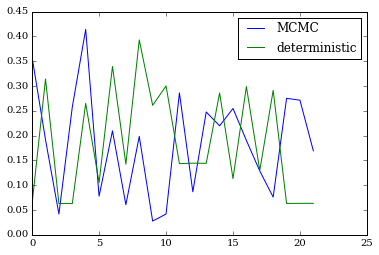

In [161]:
plt.plot(np.abs(normed_chain[-1]),label='MCMC')
plt.plot(weights,label='deterministic')
plt.legend()

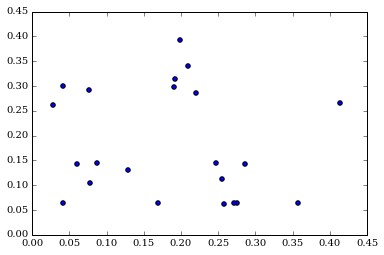

In [151]:
plt.scatter(np.abs(normed_chain[-1]),weights)

In [163]:
t

<mdtraj.Trajectory with 9999 frames, 22 atoms, 3 residues, without unitcells at 0x106810ad0>

In [169]:
from msmbuilder import featurizer


In [221]:
def compute_dev_mat(t,n=1000):
    stride = int(t.n_frames / n)
    
    dev_mat = np.zeros((n,n,t.n_atoms))
    rpf = featurizer.RawPositionsFeaturizer()
    rpft = np.array(rpf.fit_transform(t.center_coordinates())).reshape((len(t),t.n_atoms,3))
    
    for i in range(n):
        for j in range(i):
            dev_mat[i,j] = weighted_rmsd.compute_atomwise_deviation_xyz(rpft[i*stride],rpft[j*stride])
        if i%100==0:
            print(i)
    return dev_mat

In [220]:
fs_t.n_atoms

264

In [215]:
dev_mat = compute_dev_mat(t)

0
100
200
300
400
500
600
700
800
900


In [222]:
dev_mat_fs = compute_dev_mat(fs_t)

0
100
200
300
400
500
600
700
800
900


In [198]:
def distmat_plot(dist_mat_raw):
    dist_mat = dist_mat_raw + dist_mat_raw.T
    plt.imshow(dist_mat,interpolation='none',cmap='Blues')

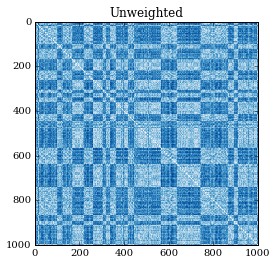

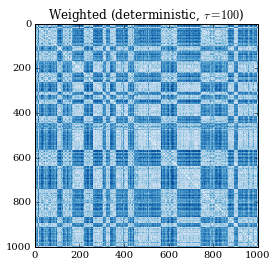

In [205]:
distmat_plot(dev_mat.dot(ones))
plt.title('Unweighted')
plt.savefig('ala_unweighted.pdf')

plt.figure()
distmat_plot(dev_mat.dot(weights_10))
plt.title(r'Weighted (deterministic, $\tau=10$)')
plt.savefig('ala_weighted_det_10.pdf')

plt.figure()
distmat_plot(dev_mat.dot(weights_100))
plt.title(r'Weighted (deterministic, $\tau=100$)')
plt.savefig('ala_weighted_det_100.pdf')

plt.figure()
distmat_plot(np.abs(dev_mat.dot(np.abs(normed_chain[-1000]))))
plt.title('Weighted (MCMC)')
plt.savefig('ala_weighted_mcmc.pdf')

In [213]:
weights_fs = compute_kinetic_weights(fs_t)

In [ ]:
def objective(weights):
    normalized_weights = norm(weights)
    return np.sum(np.dot(dev_t,normalized_weights)**2)*np.min(weights >= 0)

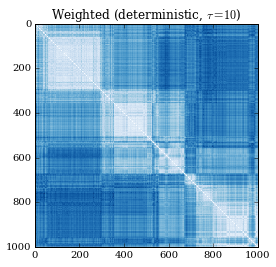

In [223]:
distmat_plot(dev_mat_fs.dot(np.ones(len(weights_fs))))
plt.title('Unweighted')
plt.savefig('fs_unweighted.pdf')

plt.figure()
distmat_plot(dev_mat_fs.dot(weights_fs))
plt.title(r'Weighted (deterministic, $\tau=10$)')
plt.savefig('fs_weighted_det.pdf')

In [209]:
sum(sampler.flatlnprobability==0) / 

4400

In [177]:
dev_mat.shape

(1000, 1000, 22)

In [230]:
dev_t_fs = windowed_deviations(fs_t)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [231]:
dev_t_fs.shape

(9909, 10, 264)

In [234]:
dev_t_fs.dot(weights_fs).shape

(9909, 10)

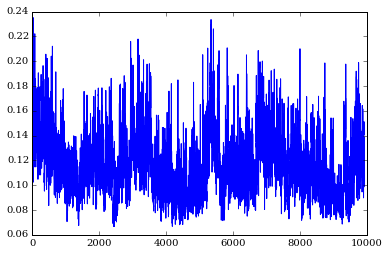

In [238]:
plt.plot(np.mean(dev_t_fs.dot(weights_fs),1))

In [777]:
def sgd(objective,dataset,init_point,batch_size=20,n_iter=100,step_size=0.01,seed=0):
    ''' objective takes in a parameter vector and an array of data'''
    np.random.seed(seed)
    testpoints = []
    testpoints = np.zeros((n_iter,len(init_point)))
    testpoints[0] = init_point
    #testpoints.append(init_point)
    #shuffled = np.array(dataset)
    #np.random.shuffle(shuffled)
    accept_frac = 1.0*batch_size/dataset.shape[0]
    ind=0
    for i in range(1,n_iter):
        max_ind = ind+batch_size
        if max_ind>=len(dataset):
            ind = max_ind % len(dataset)
            max_ind = ind+batch_size
        
        subset = dataset[ind:max_ind]
        ind = (ind + batch_size)
        #else:
        #    #new_ind = (max_ind-len(dataset))
        #    #subset = np.vstack([dataset[ind:],dataset[:new_ind]])
        #    ind = 
        #    subset = dataset[ind:batch_size]
        #    ind = batch_size
        #subset = dataset[np.random.rand(len(dataset))<accept_frac]
        obj_grad = grad(lambda p:objective(p,subset))
        raw_grad = obj_grad(testpoints[i-1])
        gradient = np.nan_to_num(raw_grad)
        #gradient = np.nan_to_num(obj_grad(testpoints[-1]))
        #print(gradient,raw_grad)
        testpoints[i] = testpoints[i-1] - gradient*step_size
        #testpoints.append(testpoints[-1] - gradient*step_size)
    return np.array(testpoints)

In [511]:
dev_t_fs.shape

(9909, 10, 264)

In [512]:
9909/9.0

1101.0

In [1088]:
def batch_objective(weights,batch,penalty_param=100):
    ''' want to minimize this objective'''
    #normalized_weights = norm(np.abs(weights))
    #return np.sum(np.abs(np.dot(batch,normalized_weights)))#-np.sum(np.abs(weights))*penalty_param
    l2_norm = np.sqrt(np.sum(weights**2))
    if l2_norm < 1:
        factor_off = 1.0/l2_norm
    else:
        factor_off=l2_norm
    #factor_off=np.max(l2_norm,1.0/l2_norm)
    functional_obj = np.sum(np.abs(np.dot(batch,weights)))
    nonneg_penalty = np.sum(penalty_param*(np.abs(weights[weights<0])))
    norm_penalty = penalty_param*(np.exp(factor_off))
    return functional_obj#+nonneg_penalty+norm_penalty

def triplet_batch_objective_simple(weights,batch,tau_1=0,tau_2=1):
    loss = 0
    for i in range(len(batch)):
        close = np.dot(dev_t[i][tau_1],weights)
        far = np.dot(dev_t[i][tau_2],weights)
        #contribution = (close-far)
        loss += contribution
        #print(close,far)
        #print(contribution)
    return loss / len(batch)

def triplet_batch_objective(weights,batch,tau_1=0,tau_2=1,tau_3=3):
    loss = 0
    for i in range(len(batch)):
        close = np.dot(dev_t[i][tau_1],weights)
        far = np.dot(dev_t[i][tau_2],weights)
        far2 = np.dot(dev_t[i][tau_3],weights)
        #contribution = np.exp(2*(close - far)/(close+far))
        #contribution = close/far
        #contribution = np.exp(close-far)
        #contribution = (close-far)
        #contribution = far-close
        #contribution=np.exp(10*(close-far))
        contribution = (((close-far)>0)*2-1)*np.exp(np.abs(5*(close-far)))
        contribution = contribution+ (((far-far2)>0)*2-1)*np.exp(np.abs(5*(far-far2)))
        #contribution = ((close-far)>0)*np.exp(np.abs(10*(close-far)))
        loss += contribution
        #print(close,far)
        #print(contribution)
    return loss / len(batch)

In [1090]:
%timeit triplet_batch_objective(weights,dev_t[:10])

1000 loops, best of 3: 307 µs per loop


In [1069]:
np.exp(-100),np.exp(100)

(3.7200759760208361e-44, 2.6881171418161356e+43)

In [1070]:
tau_1=0
tau_2=1
triplet_batch_objective(np.ones(22),dev_t,tau_1,tau_2),triplet_batch_objective(weights,dev_t,tau_1,tau_2)

(-14.252122909283733, -0.62030407272727617)

In [1091]:
raw_weights = sgd(triplet_batch_objective,dev_t,weights,n_iter=2000,step_size=0.001,batch_size=10)

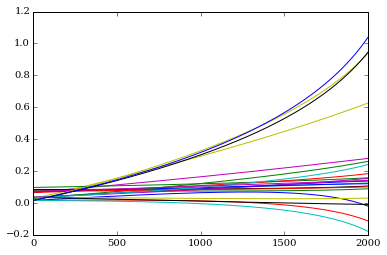

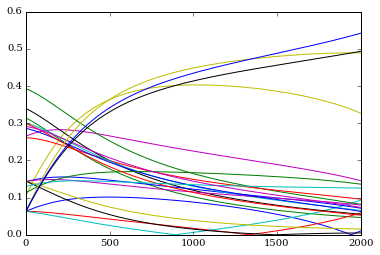

In [1092]:
plt.plot(raw_weights);
plt.figure()
normed_weights = np.array([norm(s) for s in raw_weights])
plt.plot(normed_weights);

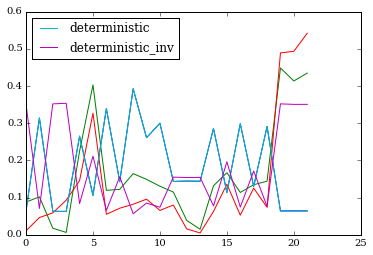

In [1093]:
plt.plot(normed_weights[1])
plt.plot(normed_weights[len(normed_weights)/2])
plt.plot(normed_weights[-1])
plt.plot(norm(norm(weights)),label='deterministic')
plt.plot(norm(1/norm(weights)),label='deterministic_inv')
plt.legend(loc='best')

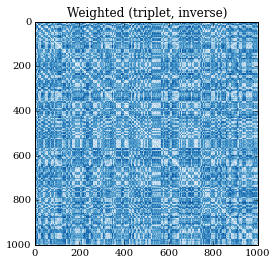

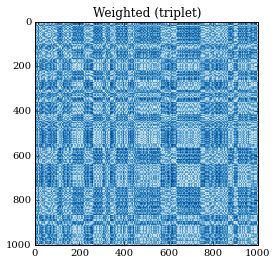

In [1094]:
distmat_plot(dev_mat.dot(norm(1/normed_weights[-1])))
plt.title('Weighted (triplet, inverse)')
plt.savefig('ala_weighted_triplet_inv.pdf')

plt.figure()
distmat_plot(dev_mat.dot(norm(normed_weights[-1])))
plt.title('Weighted (triplet)')
plt.savefig('ala_weighted_triplet.pdf')

In [1095]:
from sklearn.cluster import SpectralClustering

distmat = dev_mat.dot(norm(1/normed_weights[-1]))
distmat = distmat + distmat.T

sc = SpectralClustering(affinity='precomputed')
sc.fit(distmat)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=8, n_init=10, n_neighbors=10,
          random_state=None)

In [1096]:
eig_vals,eig_vecs = np.linalg.eigh(distmat)
plt.hist(eig_vals,bins=100);

In [1097]:
plt.plot(eig_vals[-10:])

In [1109]:
dist_mat_uw = dev_mat.dot(np.ones(22))
dist_mat_uw = dist_mat_uw + dist_mat_uw.T
eig_vals_uw,_ = np.linalg.eigh(dist_mat_uw)
plt.plot(norm(eig_vals[-50:-1][::-1]),label='weighted')
plt.plot(norm(eig_vals_uw[-50:-1][::-1]),label='unweighted')
plt.legend(loc='best')
plt.ylabel('Normalized eigenvalues')
plt.xlabel('Eigenvalue index')

In [1110]:
triplet_batch_objective(normed_weights[-1],dev_t),triplet_batch_objective(norm(1/normed_weights[-1]),dev_t)

(-1.2174985944313632, -0.75468796465818089)

In [764]:
dev_t.shape

(9908, 10, 22)

In [538]:
dev_t.shape[0]/10

990

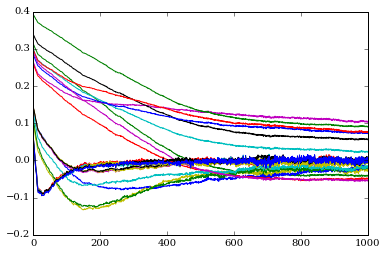

In [542]:
raw_points = sgd(batch_objective,dev_t,norm(weights),batch_size=10,n_iter=1000,step_size=0.001,seed=0)
normed_points = np.array([norm(s) for s in raw_points])
plt.plot(np.abs(normed_points));
plt.figure()
plt.plot(raw_points);

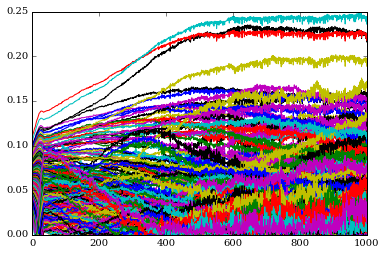

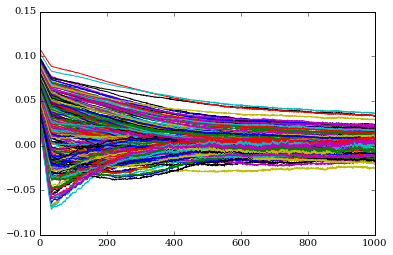

In [545]:
raw_points = sgd(batch_objective,dev_t_fs,norm(weights_fs),batch_size=10,n_iter=1000,step_size=0.0001,seed=0)
normed_points = np.array([norm(s) for s in raw_points])
plt.plot(np.abs(normed_points));
plt.figure()
plt.plot(raw_points);

In [519]:
raw_points[:100,1]

array([ 0.31414733,  0.30332838,  0.29349807,  0.28345948,  0.27782058,
        0.2749867 ,  0.2733865 ,  0.26737435,  0.26628604,  0.26243024,
        0.25947423,  0.25947423,  0.25513815,  0.25199986,  0.24987689,
        0.24987689,  0.24643087,  0.24643087,  0.24643087,  0.24643087,
        0.24643087,  0.24293042,  0.2380981 ,  0.23747412,  0.23200193,
        0.2326575 ,  0.22366119,  0.22366119,  0.22876661,  0.22154619,
        0.2257132 ,  0.2138445 ,  0.222414  ,  0.21196909,  0.21196909,
        0.21196909,  0.22004061,  0.20815076,  0.20815076,  0.21863401,
        0.2087079 ,  0.21681917,  0.21681917,  0.20514813,  0.21344224,
        0.20468115,  0.21142551,  0.19958512,  0.21087144,  0.21087144,
        0.19926102,  0.20619425,  0.20041358,  0.20041358,  0.20326625,
        0.19177422,  0.20028841,  0.18962811,  0.18962811,  0.20030296,
        0.19043069,  0.20036511,  0.19017643,  0.19644176,  0.18686938,
        0.19611237,  0.19611237,  0.19611237,  0.19611237,  0.18

In [554]:
results = [batch_objective(b,dev_t_fs) for b in normed_points[::(len(normed_points)/100)]]

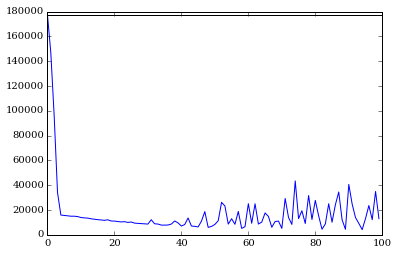

In [555]:
plt.plot(results)
plt.hlines(batch_objective(norm(weights_fs),dev_t_fs),0,len(results))

In [560]:
#for i in range(100):
#    plt.plot(np.abs(normed_points[i*10]))
plt.plot(norm(weights_fs),label='deterministic')
plt.plot(np.abs(normed_points[100]),label='SGD')
plt.legend(loc='best')

In [339]:
normed_points[1]

array([ 0.09262412,  0.083905  ,  0.15303478,  0.18383372,  0.18944637,
        0.15923845,  0.08234395,  0.12010008,  0.06150959,  0.05872907,
        0.11158566,  0.12441057,  0.1442361 ,  0.14246173,  0.04589156,
        0.06671119,  0.04316535,  0.06148455,  0.05025831,  0.08896815,
        0.09112393,  0.11873766,  0.12467369,  0.11665577,  0.0116853 ,
        0.04824015, -0.02087788, -0.01734914,  0.01202569,  0.03310767,
        0.07431809,  0.1280293 ,  0.09774977,  0.10695625,  0.00746239,
        0.04993101, -0.01391455, -0.01316326,  0.00368581,  0.02962098,
        0.03949316,  0.07508904,  0.06545504,  0.06961499, -0.01246463,
        0.02332599, -0.03021613, -0.0061458 , -0.02718408, -0.0082692 ,
        0.0010858 ,  0.03862725,  0.047269  ,  0.04995896, -0.04581255,
       -0.05739671, -0.02483093, -0.00207665, -0.02111347, -0.01448523,
        0.00784799,  0.03094038,  0.04133141,  0.05483837, -0.03265709,
       -0.02083627, -0.02920801, -0.01464491, -0.01758712, -0.00

In [241]:
a = np.ones(10)
a[5:15]

array([ 1.,  1.,  1.,  1.,  1.])

In [ ]:
def 

In [ ]:
objective

In [ ]:
plt.plot(diffs.mean(0)[1:],label='Mean')
plt.plot(np.median(diffs[:,1:],0),label='Median')
#plt.plot(np.min(diffs[:,1:],0),label='Min')
#plt.plot(np.max(diffs[:,1:],0),label='Max')
plt.xlabel(r'Time lag ($\tau$)')
plt.ylabel('RMSD')
plt.legend(loc='best')
plt.title('Fs Peptide')

In [178]:
dev_mat.dot(weights).shape

(1000, 1000)

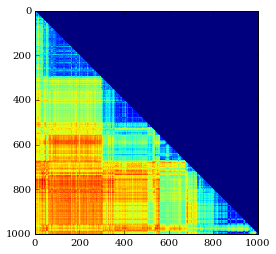

In [297]:
plt.imshow(dev_mat_fs.dot(weights_fs))

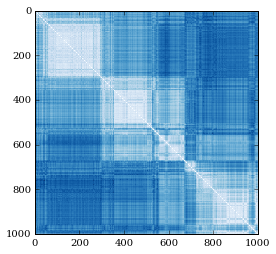

In [298]:
distmat_plot(dev_mat_fs.dot(weights_fs))

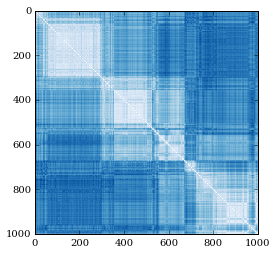

In [546]:
distmat_plot(dev_mat_fs.dot(np.abs(normed_points[-1])))

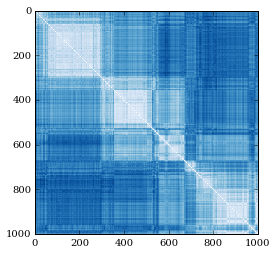

In [547]:
distmat_plot(dev_mat_fs.dot(np.ones(len(weights_fs))))

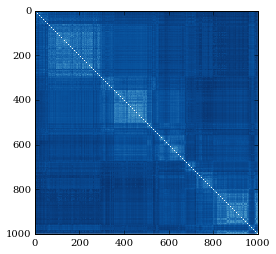

In [561]:
distmat_plot(dev_mat_fs.dot(norm(np.ones(len(weights_fs)))) / (1+dev_mat_fs.dot(np.abs(normed_points[100]))))

In [ ]:
# other idea: compute a gradient based on kinetically near/far triplets

In [568]:
batch = dev_t[:100]

In [564]:
def penalty(metric,center,close,far,inf=10000):
    ''' compute d_metric(center,close) and d_metric(center,far), and penalize 
    (d_metric(center,close)/d_metric(center,far)) -- i.e. we want the distance from the center point
    to the "close" point to be small relative to the distance from the center point to the "far" point'''
    d_far = metric(center,far)
    d_close = metric(center,close)
    return d_close/d_far

In [570]:
tau_1=1
tau_2=10
triplets = np.array([(batch[i],batch[i+tau_1],batch[i+tau_2]) for i in range(len(batch)-tau_2)])
triplets.shape

(90, 3, 10, 22)

In [572]:
triplets[0].shape

(3, 10, 22)

In [575]:
from msmbuilder.featurizer import DihedralFeaturizer
dihedrals = DihedralFeaturizer().transform([t])[0]
dihedrals.shape

(9999, 4)

In [612]:
dihedrals_fs = DihedralFeaturizer().transform([fs_t])[0]

In [577]:
from scipy.spatial.distance import euclidean

In [595]:
def near_far_triplet_loss(metric,batch,tau_1=1,tau_2=10):
    ''' batch is a numpy array of time-ordered observations'''
    #triplets = np.array([(batch[i],batch[i+tau_1],batch[i+tau_2]) for i in range(len(batch)-tau_2)])
    cost=0
    n_triplets = len(batch)-tau_2
    for i in range(n_triplets):
        cost+=penalty(metric,batch[i],batch[i+tau_1],batch[i+tau_2])
    return cost / n_triplets

In [596]:
near_far_triplet_cost(euclidean,dihedrals)

0.8897582722030105

In [597]:
def triplet_wrmsd_loss(weights,dataset,tau_1=1,tau_2=10):
    ''' given a weight vector and a dataset, compute the
    '''
    metric = lambda x,y:wRMSD(x,y,weights)
    return near_far_triplet_loss(metric,dataset,tau_1,tau_2)

In [598]:
def generate_triplet_weighted_metric_loss(weighted_metric,tau_1=1,tau_2=10):
    return lambda weights,dataset:near_far_triplet_loss(lambda x,y:weighted_metric(x,y,weights),dataset,tau_1,tau_2)

In [601]:
def weighted_dot_prod(x,y,weights):
    return np.dot(x*weights,y)

In [640]:
from scipy.spatial.distance import mahalanobis
mahalanobis(x,y,np.diag(np.ones(len(x))))

0.42989719828259687

In [642]:
euclidean(x,y)

0.4298971891403198

In [603]:
generate_triplet_weighted_metric_loss(weighted_dot_prod)(np.ones(4),dihedrals)

0.38391835095146271

In [643]:
generate_triplet_weighted_metric_loss(mahalanobis)(np.diag(np.ones(len(x))),dihedrals)

0.88975827169429644

In [ ]:
grad(

In [586]:
x = dihedrals[0]
y = dihedrals[1]
x.T.dot(y)

1.9075942

In [590]:
(x*np.ones(len(x))).dot(y)

1.9075942020746846

In [634]:
raw_points = sgd(generate_triplet_weighted_metric_loss(weighted_dot_prod),dihedrals,np.ones(4),batch_size=100,step_size=0.001)

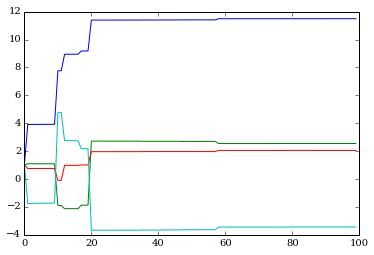

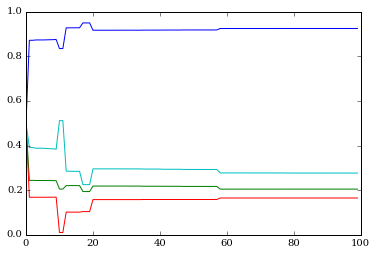

In [637]:
plt.plot(raw_points);
normed_points = np.array([norm(s) for s in raw_points])
plt.figure()
plt.plot(normed_points);

In [631]:
raw_points = sgd(generate_triplet_weighted_metric_loss(weighted_dot_prod),dihedrals_fs,np.ones(dihedrals_fs.shape[1]),n_iter=1000,batch_size=30,step_size=0.1)

In [632]:
normed_points = np.array([norm(s) for s in raw_points])

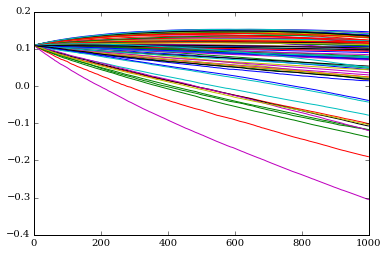

In [633]:
plt.plot(raw_points);
plt.figure()
plt.plot(normed_points);

In [747]:
def np_mahalanobis(x,y,A_vec):
    A = np.diag(A_vec)
    return np.sqrt(np.dot(np.dot(x,A),np.dot(y,A)))

In [749]:
raw_points = sgd(objective=generate_triplet_weighted_metric_loss(np_mahalanobis,tau_1=1,tau_2=5),
                 dataset=dihedrals,init_point=np.random.rand(4),batch_size=20,step_size=0.1,n_iter=1000)

In [653]:
def projected_distance(x,y,A):
    return np.sqrt(np.dot(np.dot(x,A),np.dot(y,A)))

In [667]:
def projected_distance_vec(x,y,A_vec):
    A = np.reshape(A_vec,(len(x),len(A_vec)/len(x)))
    return projected_distance(x,y,A)

In [734]:
raw_points = sgd(objective=generate_triplet_weighted_metric_loss(projected_distance_vec,tau_1=1,tau_2=5),
                 dataset=dihedrals,init_point=np.random.rand(8),batch_size=20,step_size=0.1,n_iter=1000)

In [735]:
np.dot(dihedrals,np.reshape(raw_points[-1],(4,2))).shape

(9999, 2)

In [750]:
plt.plot(raw_points);

In [752]:
normed_points = np.array([norm(s) for s in raw_points])
plt.plot(normed_points);

In [760]:
reload(weighted_rmsd)
from weighted_rmsd import wRMSD_xyz

In [761]:
raw_points = sgd(objective=generate_triplet_weighted_metric_loss(wRMSD_xyz,tau_1=1,tau_2=5),
                 dataset=t,init_point=np.random.rand(4),batch_size=20,step_size=0.1,n_iter=10)

ValueError: sequence too large; must be smaller than 32

In [ ]:
wRMSD(

In [753]:
grad(lambda weights:generate_triplet_weighted_metric_loss(projected_distance_vec,tau_1=1,tau_2=5)(weights,dihedrals))(np.ones(8))

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [745]:
projected_distance_vec(dihedrals[10],dihedrals[10],np.ones(8))

1.8950667884464911